# Decode context from spikes or facemap

1 - either use all annotated & uploaded ephys sessions as input or provide a list of session_ids

2 - set a savepath and filename for the output - one .pkl file per session

3 - set parameters - descriptions below

4 - run decoding!

In [8]:
import sys
# sys.path.append(r"C:\Users\shailaja.akella\Dropbox (Personal)\DR\dynamic_routing_analysis_ethan\src")

import npc_lims
from dynamic_routing_analysis import decoding_utils, path_utils
from npc_sessions import DynamicRoutingSession
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import pandas as pd
import upath

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#1A get all uploaded & annotated ephys sessions

ephys_sessions = tuple(s for s in npc_lims.get_session_info(is_ephys=True, is_uploaded=True, 
                                                            is_annotated=True, project='DynamicRouting', issues = []))

In [90]:
#1B alternatively, provide a list of session ids:
# session_id_list=['733891_2024-09-19','712815_2024-05-22','708016_2024-05-01','664851_2023-11-14','702136_2024-03-05','686176_2023-12-05']
# session_id_list=['703333_2024-04-08']
session_id_list=['668755_2023-08-30']
# session_id_list=['667252_2023-09-25'] #only 4 blocks - test error handling
session_list=[]
for ss in session_id_list:
    session_list.append(npc_lims.get_session_info(ss))
ephys_sessions=tuple(session_list)
ephys_sessions

(SessionInfo(id='668755_2023-08-30', project='DynamicRouting', is_ephys=True, is_sync=True, allen_path=WindowsUPath('//allen/programs/mindscope/workgroups/dynamicrouting/PilotEphys/Task 2 pilot/DRpilot_668755_20230830'), experiment_day=3, session_kwargs={}, notes='', issues=[]),)

In [91]:
#2 set savepath and filename
savepath=upath.UPath(r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\test_stim_decoding")
filename='test_stim_decoding.pkl'

# filename='2024_10_28'
# savepath = path_utils.DECODING_ROOT_PATH / 'decoding_test_2024_10_28'

except_list={}

#3 set parameters
#linear shift decoding currently just takes the average firing rate over all bins defined here
# spikes_binsize=0.2 #bin size in seconds
# spikes_time_before=0.2 #time before the stimulus per trial
# spikes_time_after=0.01 #time after the stimulus per trial
spikes_binsize=0.1 #bin size in seconds
spikes_time_before=0.0 #time before the stimulus per trial
spikes_time_after=0.11 #time after the stimulus per trial

# #not used for linear shift decoding, were used in a previous iteration of decoding analysis
# decoder_binsize=0.2
# decoder_time_before=0.2
# decoder_time_after=0.1


params = {
    'n_units': ['all'], #number of units to sample for each area (list)
    'n_repeats': 25,  # number of times to repeat decoding with different randomly sampled units
    'input_data_type': 'spikes',  # spikes or facemap or LP
    'vid_angle_facemotion': 'face', # behavior, face, eye
    'vid_angle_LP': 'behavior',
    'central_section': '4_blocks_plus',
    'predict': 'context', # 'context' or 'vis_appropriate_response'
    # for linear shift decoding, how many trials to use for the shift. '4_blocks_plus' is best
    'exclude_cue_trials': False,  # option to totally exclude autorewarded trials
    'n_unit_threshold': 20,  # minimum number of units to include an area in the analysis
    'keep_n_SVDs': 500,  # number of SVD components to keep for facemap data
    'LP_parts_to_keep': ['ear_base_l', 'eye_bottom_l', 'jaw', 'nose_tip', 'whisker_pad_l_side'],
    'spikes_binsize': spikes_binsize,
    'spikes_time_before': spikes_time_before,
    'spikes_time_after': spikes_time_after,
    # 'decoder_binsize':decoder_binsize,
    # 'decoder_time_before':decoder_time_before,
    # 'decoder_time_after':decoder_time_after,
    'savepath': savepath,
    'filename': filename,
    'use_structure_probe': True,  # if True, append probe name to area name when multiple probes in the same area
    'crossval': '5_fold_constant',  # '5_fold', '5_fold_constant', or 'blockwise' - blockwise untested with linear shift
    'labels_as_index': True,  # convert labels (context names) to index [0,1]
    'decoder_type': 'LogisticRegression',  # 'linearSVC' or 'LDA' or 'RandomForest' or 'LogisticRegression'
    'only_use_all_units': False, #if True, do not run decoding with different areas, only with all areas -- for debugging
    'return_results': True,  # if True, return the results of the decoding analysis
}


for ephys_session in ephys_sessions[:1]:
    # if os.path.exists(savepath + '/' + ephys_session.id[:17] + '_' + filename + '.pkl'): 
    #     print(ephys_session.id[:17] + ' completed, skipping...')    
    #     continue
    # try:
        session = DynamicRoutingSession(ephys_session.id)
        print(session.id+' loaded')
        if 'structure' in session.electrodes[:].columns:
            session_info=ephys_session
            session_id=str(session_info.id)
            trials=pd.read_parquet(
                npc_lims.get_cache_path('trials',session_id,'any')
            )
            units=pd.read_parquet(
                npc_lims.get_cache_path('units',session_id,'any')
            )
            
            results=decoding_utils.decode_stimulus_across_context(session=None,params=params,trials=trials,units=units,session_info=session_info)
            
            # decoding_utils.decode_context_with_linear_shift(session=None,params=params,trials=trials,units=units,session_info=session_info)

            # #find path of decoder result
            # file_path= savepath / (ephys_session.id[:17] + '_' + filename)

            # decoding_results=decoding_utils.concat_decoder_results(file_path,savepath=savepath,return_table=True,single_session=True)

            # #find n_units to loop through for next step
            # if decoding_results is not None:
            #     n_units=[]
            #     for col in decoding_results.filter(like='true_accuracy_').columns.values:
            #         if len(col.split('_'))==3:
            #             temp_n_units=col.split('_')[2]
            #             try:
            #                 n_units.append(int(temp_n_units))
            #             except:
            #                 n_units.append(temp_n_units)
            #         else:
            #             n_units.append(None)

            #     for nu in n_units:
            #         decoding_utils.concat_trialwise_decoder_results(file_path,savepath=savepath,return_table=False,n_units=nu,single_session=True)

        else:
            print('no structure column found in electrodes table, moving to next recording')
        session=[]
    # except Exception as e:
        # except_list[session.id]=repr(e)


668755_2023-08-30_0 loaded


c:\Anaconda3\envs\dr_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda3\envs\dr_anal

PermissionError: [Errno 13] Permission denied: '\\\\allen\\programs\\mindscope\\workgroups\\templeton\\TTOC\\decoding results\\test_stim_decoding\\668755_2023-08-30_test_stim_decoding.pkl'

Text(0.5, 1.0, 'Decoding accuracy for ORBl')

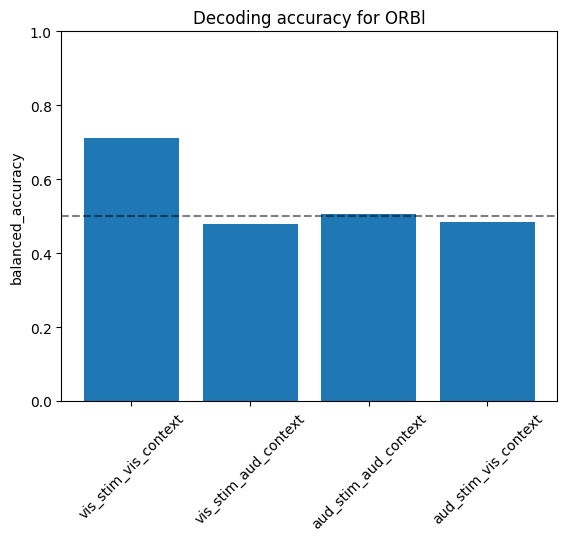

In [89]:
sel_area='ORBl'

vis_stim_vis_context=results['703333_2024-04-08']['results'][sel_area]['predict_vis_stim_vis_context']['all'][0]['balanced_accuracy_test']
vis_stim_aud_context=results['703333_2024-04-08']['results'][sel_area]['predict_vis_stim_aud_context']['all'][0]['balanced_accuracy_test']
aud_stim_aud_context=results['703333_2024-04-08']['results'][sel_area]['predict_aud_stim_aud_context']['all'][0]['balanced_accuracy_test']
aud_stim_vis_context=results['703333_2024-04-08']['results'][sel_area]['predict_aud_stim_vis_context']['all'][0]['balanced_accuracy_test']

fig,ax=plt.subplots(1,1)
ax.bar(np.arange(0,4),[vis_stim_vis_context,vis_stim_aud_context,aud_stim_aud_context,aud_stim_vis_context])
ax.axhline(0.5,color='black',linestyle='--',alpha=0.5)
ax.set_xticks(np.arange(0,4))
ax.set_xticklabels(['vis_stim_vis_context','vis_stim_aud_context','aud_stim_aud_context','aud_stim_vis_context'],rotation=45)
ax.set_ylabel('balanced_accuracy')
ax.set_ylim(0,1)

ax.set_title('Decoding accuracy for '+sel_area)


In [31]:
units['structure'].unique()

array(['CA1', 'CA3_probeE', 'CA3_probeC', 'CA3_probeD', 'CM', 'CS',
       'DG_probeD', 'DG_probeC', 'FRP', 'HPF', 'LGd', 'MB', 'MGd', 'MGm',
       'MGv', 'MOs', 'MRN', 'OLF', 'ORBl', 'PAG', 'Pa4', 'RSPd',
       'RSPv_probeF', 'RSPv_probeC', 'SCdg', 'SCdw', 'SCig', 'SCiw',
       'SCop', 'SCsg', 'SCzo', 'SSp', 'V3', 'out of brain_probeA',
       'out of brain_probeE'], dtype=object)